In [ ]:
!pip install transformers

In [13]:
!pip install catboost

In [ ]:
!pip install scikit-plot

In [15]:
!pip install shap

In [16]:
import pandas as pd
import numpy as np
import random
import shap
import scikitplot as skplt
import seaborn as sns
import scipy as sp
import plotly.express as px
import matplotlib.pyplot as plt


from collections import Counter
from scipy.special import softmax

%matplotlib inline

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split as tts

from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MaxAbsScaler

from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier

from tqdm import tqdm

np.random.seed(42)
random.seed(42)

In [ ]:
!pip install pymorphy2
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from pymorphy2 import MorphAnalyzer
from multiprocessing import Pool
from tqdm import tqdm

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

In [ ]:
!pip uninstall -y transformers accelerate
!pip install transformers accelerate

In [10]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForPreTraining,AutoModel

from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
from transformers import Trainer, TrainingArguments
from IPython.display import clear_output

In [11]:
import warnings
warnings.filterwarnings('ignore')

# EDA

In [23]:
df = pd.read_csv("/content/train_spam.csv")
df

text_type                                               text
0           ham  make sure alex knows his birthday is over in f...
1           ham  a resume for john lavorato thanks vince i will...
2          spam  plzz visit my website moviesgodml to get all m...
3          spam  urgent your mobile number has been awarded wit...
4           ham  overview of hr associates analyst project per ...
...         ...                                                ...
16273      spam  if you are interested in binary options tradin...
16274      spam  dirty pictureblyk on aircel thanks you for bei...
16275       ham  or you could do this g on mon 1635465 sep 1635...
16276       ham  insta reels par 80 गंद bhara pada hai 👀 kuch b...
16277       ham  alex s paper comments 1 in the sentence betwee...

[16278 rows x 2 columns]

Проверим на дубликаты

In [24]:
duplicateRows = df[df['text'].duplicated ()]
duplicateRows

text_type                                               text
4145        ham  SPAM ALERT  🚔  User:     Username: @DillyBubbl...
4463        ham  SPAM ALERT  🚔  User:     Username: @DillyBubbl...
5640        ham                                               /ban
6933        ham  SPAM ALERT  🚔  User:     Username: @DillyBubbl...
7663        ham  SPAM ALERT  🚔  User:     Username: @DillyBubbl...
7918        ham  SPAM ALERT  🚔  User:     Username: @DillyBubbl...
9790        ham  SPAM ALERT  🚔  User:     Username: @DillyBubbl...
10290       ham  SPAM DETECTION  User:     Username: @DillyBubb...
10811       ham  SPAM DETECTION  User:     Username: @DillyBubb...
13210       ham  SPAM DETECTION  User:     Username: @DillyBubb...
14267       ham                                               /ban

Удалим все дубликаты, так как их мало

In [25]:
df = df.drop_duplicates('text')
df

text_type                                               text
0           ham  make sure alex knows his birthday is over in f...
1           ham  a resume for john lavorato thanks vince i will...
2          spam  plzz visit my website moviesgodml to get all m...
3          spam  urgent your mobile number has been awarded wit...
4           ham  overview of hr associates analyst project per ...
...         ...                                                ...
16273      spam  if you are interested in binary options tradin...
16274      spam  dirty pictureblyk on aircel thanks you for bei...
16275       ham  or you could do this g on mon 1635465 sep 1635...
16276       ham  insta reels par 80 गंद bhara pada hai 👀 kuch b...
16277       ham  alex s paper comments 1 in the sentence betwee...

[16267 rows x 2 columns]

In [26]:
df.isna().sum()

text_type    0
text         0
dtype: int64

Видим, что в данных нет пропусков

Сразу закодируем целевую переменную

In [27]:
le = LabelEncoder()
le.fit(df['text_type'])
df['text_type_cod'] = le.transform(df['text_type'])
df

text_type                                               text  \
0           ham  make sure alex knows his birthday is over in f...   
1           ham  a resume for john lavorato thanks vince i will...   
2          spam  plzz visit my website moviesgodml to get all m...   
3          spam  urgent your mobile number has been awarded wit...   
4           ham  overview of hr associates analyst project per ...   
...         ...                                                ...   
16273      spam  if you are interested in binary options tradin...   
16274      spam  dirty pictureblyk on aircel thanks you for bei...   
16275       ham  or you could do this g on mon 1635465 sep 1635...   
16276       ham  insta reels par 80 गंद bhara pada hai 👀 kuch b...   
16277       ham  alex s paper comments 1 in the sentence betwee...   

       text_type_cod  
0                  0  
1                  0  
2                  1  
3                  1  
4                  0  
...              ...  
16273              1  
16274              1  
16275              0  
16276              0  
16277              0  

[16267 rows x 3 columns]

Посмотрим на несколько примеров из кажого класса

In [28]:
for i in df[df['text_type'] == 'ham'].sample(n=5)['text']:
    print('Example: ',i)
    print('_'*50)

Example:  ü predict wat time üll finish buying
__________________________________________________
Example:  s now only i took tablets reaction morning only
__________________________________________________
Example:  url evangelicals threat to new archbishop direct action threat over liberal views on sexuality stephen bates religious affairs correspondent tuesday october 1635465 1635465 the guardian evangelical fundamentalists last night stepped up their campaign to oust rowan williams the incoming archbishop of canterbury before he even takes up his post by threatening to take direct action against him the council of the church society the church of england s oldest evangelical body joined a younger evangelical pressure group called reform which is also opposed to dr williams in calling on him to recant his supposedly liberal views on sexuality or stand down following an emergency meeting the 1635465 year old society whose leaders met the archbishop last week proclaimed their continue

In [29]:
for i in df[df['text_type'] == 'spam'].sample(n=5)['text']:
    print('Example: ',i)
    print('_'*50)

Example:  newsletter coach invest septembre 1635465 coach invest l accompagnateur des jeunes entreprises url ou 1635465 coachinvest 1635465 1635465 euros min des nouvelles de coach invest 1635465 lancement réussi pour coach invest interactive qui décroche ses premiers contrats coach invest interactive accompagne les entreprises dans la création le développement l optimisation et la gestion au quotidien de leur site internet coach invest interactive propose à ses clients de nombreux services afin de les aider à concevoir et à mettre en place leur stratégie internet contact hugo beaulieu tél 1635465 1635465 1635465 1635465 1635465 1635465 1635465 1635465 1635465 1635465 e mail webmaster url pour en savoir plus url 1635465 coach invest a investi dans deux nouvelles entreprises inqual inqual est une soc
__________________________________________________
Example:  nlimited internet surfing 200 mb tak poore 3 din ke liye sirf rs18 mein dial karein 56713 ya rs18 se recharge karein free usage 

Видим, что `spam` часто связан с заработком

Посмотрим распределение классов

In [30]:
fig = px.histogram(df,
             x = 'text_type',
             color = 'text_type',
             barmode = 'group',
             text_auto = True,
             title = 'Class distribution in the data'
             )

fig.show();

Видим соотношение 2 к 1 в в пользу `ham`

Теперь посмотрим на распределение длин сообщейни каждого из классов

In [31]:
df['sym_len'] = df.text.apply(len)
df['word_len'] = df.text.apply(lambda x: len(x.split()))

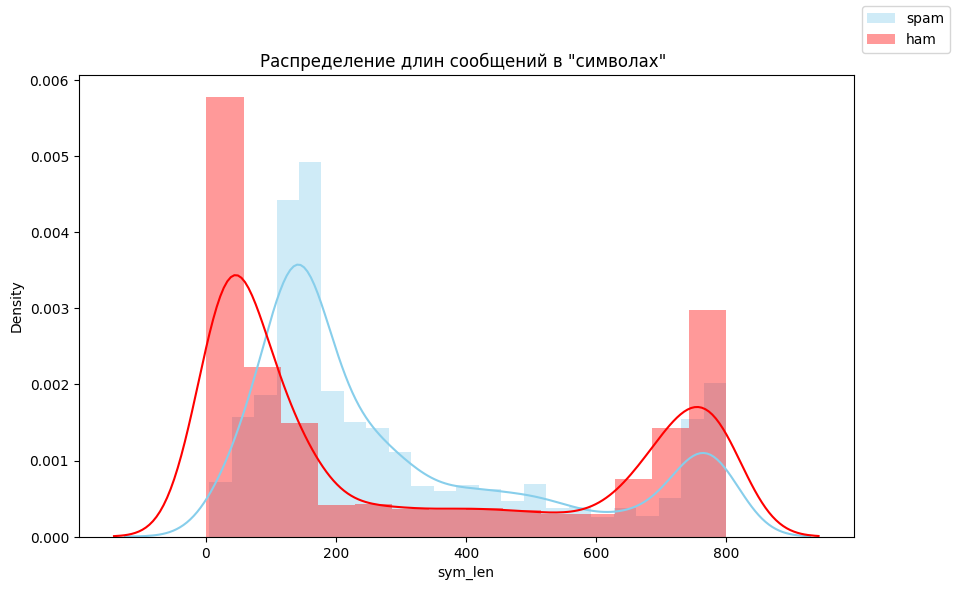

In [32]:
fig = plt.figure(figsize=(10,6))
sns.distplot(df[df["text_type"] =='spam']["sym_len"] , color="skyblue", label='spam');
sns.distplot(df[df["text_type"] =='ham']["sym_len"] , color="red", label='ham');
plt.title('Распределение длин сообщений в "символах" ')
fig.legend()
plt.show()

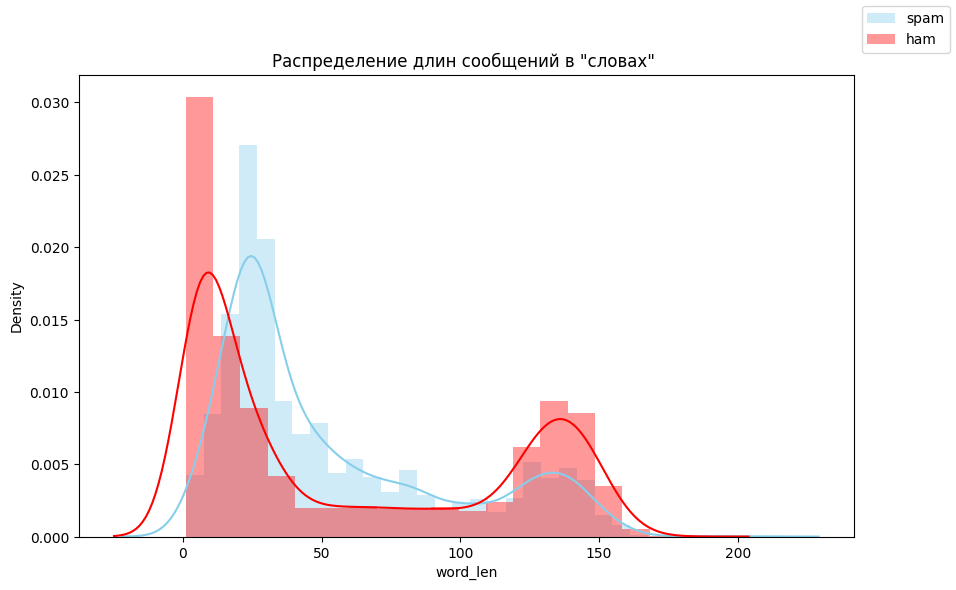

In [33]:
fig = plt.figure(figsize=(10,6))
sns.distplot(df[df["text_type"] =='spam']["word_len"] , color="skyblue", label='spam');
sns.distplot(df[df["text_type"] =='ham']["word_len"] , color="red", label='ham');
plt.title('Распределение длин сообщений в "словах" ')
fig.legend()
plt.show()

Видно, что распределение длин сообщений `spam` сдвинуто вправо относительно распределения длин сообщений `ham`

Вернемся к нашей теории о связи зароботка и `spam` и создадим фичу `profit`

In [34]:
def count_m(s):
    return s.count('$')

In [35]:
df['profit'] = df.text.apply(lambda x: count_m(x))
df

text_type                                               text  \
0           ham  make sure alex knows his birthday is over in f...   
1           ham  a resume for john lavorato thanks vince i will...   
2          spam  plzz visit my website moviesgodml to get all m...   
3          spam  urgent your mobile number has been awarded wit...   
4           ham  overview of hr associates analyst project per ...   
...         ...                                                ...   
16273      spam  if you are interested in binary options tradin...   
16274      spam  dirty pictureblyk on aircel thanks you for bei...   
16275       ham  or you could do this g on mon 1635465 sep 1635...   
16276       ham  insta reels par 80 गंद bhara pada hai 👀 kuch b...   
16277       ham  alex s paper comments 1 in the sentence betwee...   

       text_type_cod  sym_len  word_len  profit  
0                  0       86        16       0  
1                  0      520        97       0  
2                  1      126        22       0  
3                  1      139        23       0  
4                  0      733       127       0  
...              ...      ...       ...     ...  
16273              1      114        18       0  
16274              1      454        73       0  
16275              0      799       147       0  
16276              0      102        21       0  
16277              0      745       140       0  

[16267 rows x 6 columns]

In [36]:
df[df['profit']>0]['text_type'].value_counts()

text_type
spam    400
ham      14
Name: count, dtype: int64

Видно, что наличие `$` дает неплохое понимание, что перед нами `spam`

# Models

## Logistic Regression

Попробуем построить предсказания тольк она основе длинны и наличия `$`

In [37]:
numerical_transformer = Pipeline(steps = [
    ('scaler',StandardScaler())])

preprocessor = ColumnTransformer(
    transformers = [
        ('num',numerical_transformer, ['sym_len','word_len','profit'])
    ])

In [38]:
X = df[['sym_len','word_len','profit']]
y = df['text_type']
X_train, X_test, y_train, y_test = tts(X, y,random_state=42, train_size=0.7, shuffle=True)

Accuracy: 0.720139315713993
F1: 0.5018643535951228
AUC: 0.6541460026978237


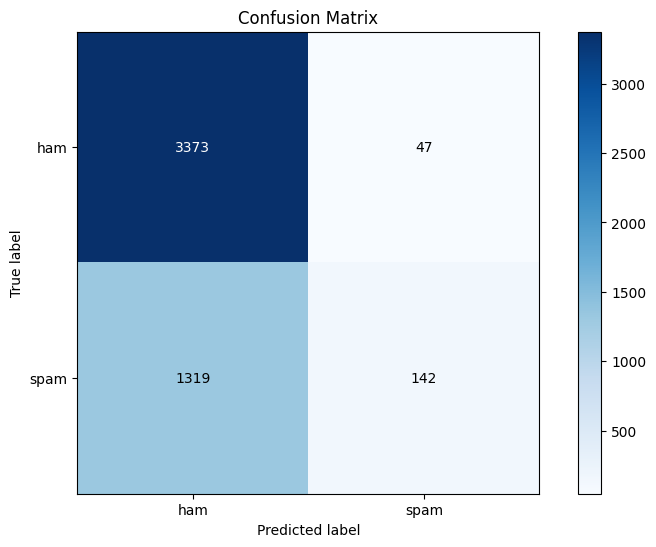

In [39]:
clf = LogisticRegression()

pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', clf)
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print('Accuracy:',accuracy_score(y_pred, y_test))
print('F1:',f1_score(y_pred, y_test, average='macro'))
print('AUC:', roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1]))
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=False, figsize=(10,6))
plt.show()

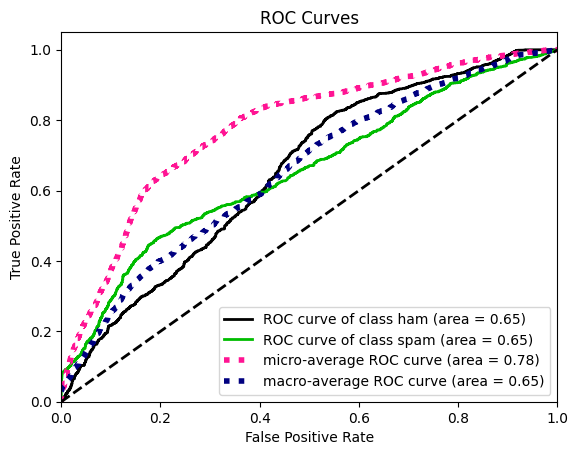

In [40]:
skplt.metrics.plot_roc_curve(y_test, pipeline.predict_proba(X_test))
plt.show()

Неплохой результат, но можно лучше)

## Tf-idf

Попробуем классику классификации спама 00х ;)

Перед векторизацией удалим стоп словаи лемматизацию

In [41]:
m = MorphAnalyzer()
regex = re.compile("[A-z]+")
mystopwords = stopwords.words('english')

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]

def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)
    return ' '.join(remove_stopwords(lemmas))

In [42]:
from multiprocessing import Pool as PoolSklearn

with PoolSklearn(4) as p:
    df['text_lemmas'] = list(tqdm(p.imap(clean_text, df['text']), total=len(df)))
df

100%|██████████| 16267/16267 [00:33<00:00, 490.82it/s]


text_type                                               text  \
0           ham  make sure alex knows his birthday is over in f...   
1           ham  a resume for john lavorato thanks vince i will...   
2          spam  plzz visit my website moviesgodml to get all m...   
3          spam  urgent your mobile number has been awarded wit...   
4           ham  overview of hr associates analyst project per ...   
...         ...                                                ...   
16273      spam  if you are interested in binary options tradin...   
16274      spam  dirty pictureblyk on aircel thanks you for bei...   
16275       ham  or you could do this g on mon 1635465 sep 1635...   
16276       ham  insta reels par 80 गंद bhara pada hai 👀 kuch b...   
16277       ham  alex s paper comments 1 in the sentence betwee...   

       text_type_cod  sym_len  word_len  profit  \
0                  0       86        16       0   
1                  0      520        97       0   
2                  1      126        22       0   
3                  1      139        23       0   
4                  0      733       127       0   
...              ...      ...       ...     ...   
16273              1      114        18       0   
16274              1      454        73       0   
16275              0      799       147       0   
16276              0      102        21       0   
16277              0      745       140       0   

                                             text_lemmas  
0      make sure alex knows birthday fifteen minutes ...  
1      resume john lavorato thanks vince moving right...  
2      plzz visit website moviesgodml movies free als...  
3      urgent mobile number awarded prize guaranteed ...  
4      overview associates analyst project david requ...  
...                                                  ...  
16273  interested binary options trading continue inf...  
16274  dirty pictureblyk aircel thanks valued member ...  
16275  could david rees wrote wrote razor spamassassi...  
16276  insta reels bhara pada kuch dalte cringe somet...  
16277  alex paper comments sentence think annualized ...  

[16267 rows x 7 columns]

### SVD

Посмотрим на полученное с помощью SVD двумерное представление представление матрицы Tf-idf

In [43]:
tf_idf = TfidfVectorizer(ngram_range=(1, 3))
data_vec = tf_idf.fit_transform(df['text_lemmas'])

n_components = 2
pca = TruncatedSVD(n_components)
pca.fit(data_vec)

pca_data = pca.transform(data_vec)

labels = {str(i): f"Сomponent {i+1}" for i in range(n_components)}
labels['color'] = 'text_type'

fig = px.scatter(
    pca_data,
    x=0, y=1,
    color=df.text_type,
    labels=labels,
    title=f'SVD Transformed Data',
)
fig.show()

Видно, что данные хорошо раздедимы визуально

In [44]:
X = df[['sym_len','word_len','profit','text_lemmas']]
y = df['text_type']
X_train, X_test, y_train, y_test = tts(X, y,random_state=42, train_size=0.7, shuffle=True)

In [45]:
numerical_transformer = Pipeline(steps = [
    ('scaler',MaxAbsScaler())])

text_transformer = Pipeline(steps = [
    ('Tf-idf',TfidfVectorizer(ngram_range=(1, 3)))
])

preprocessor = ColumnTransformer(
    transformers = [
        ('num',numerical_transformer, ['sym_len','word_len','profit']),
        ('text',text_transformer, 'text_lemmas')
    ])

In [46]:
pipeline_transformer = Pipeline(steps = [
    ('preprocessor', preprocessor)
])

In [47]:
X = df[['sym_len','word_len','profit','text_lemmas']]
y = df['text_type']
X_train, X_test, y_train, y_test = tts(X, y,random_state=42, train_size=0.7, shuffle=True)

### Naive Bayes

Accuracy: 0.7955337021102233
F1: 0.6821779643367729
AUC: 0.8989907177251824


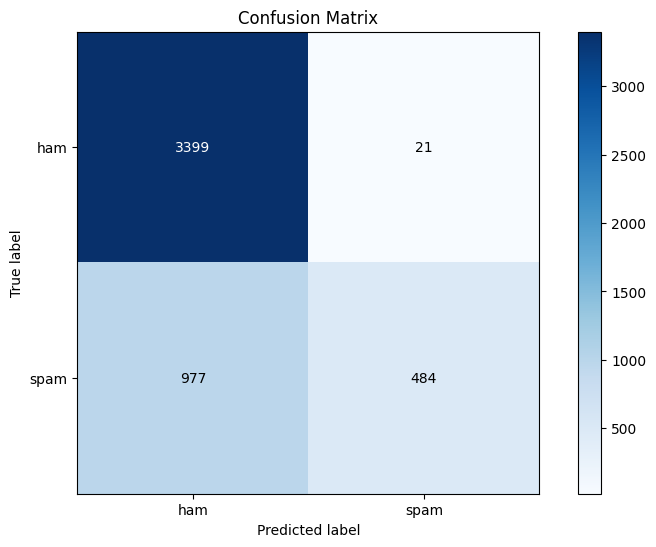

In [48]:
clf = MultinomialNB()

pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', clf)
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print('Accuracy:',accuracy_score(y_pred, y_test))
print('F1:',f1_score(y_pred, y_test, average='macro'))
print('AUC:', roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1]))
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=False, figsize=(10,6))
plt.show()

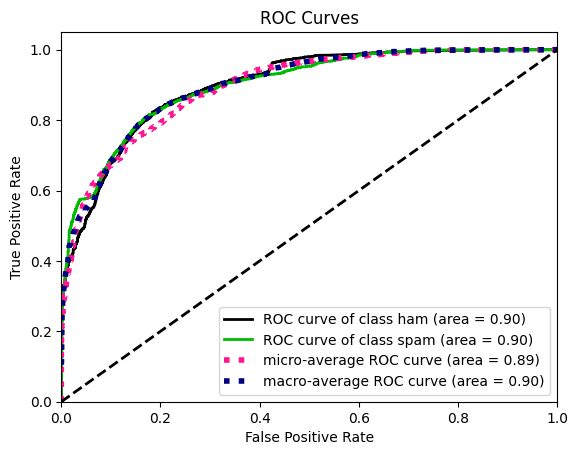

In [49]:
skplt.metrics.plot_roc_curve(y_test, pipeline.predict_proba(X_test))
plt.show()

### LogisticRegression + features importance

Accuracy: 0.8901864372054907
F1: 0.8578856521553968
AUC: 0.9624055861762552


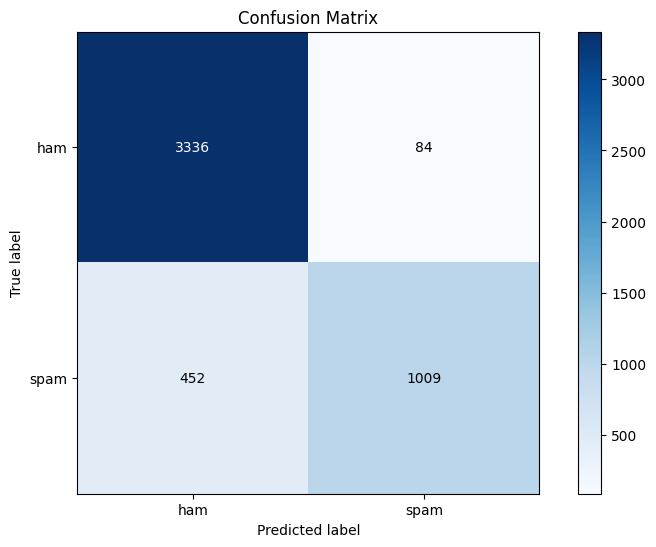

In [50]:
clf = LogisticRegression(penalty='l2', solver='liblinear')

pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', clf)
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print('Accuracy:',accuracy_score(y_pred, y_test))
print('F1:',f1_score(y_pred, y_test, average='macro'))
print('AUC:', roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1]))
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=False, figsize=(10,6))
plt.show()

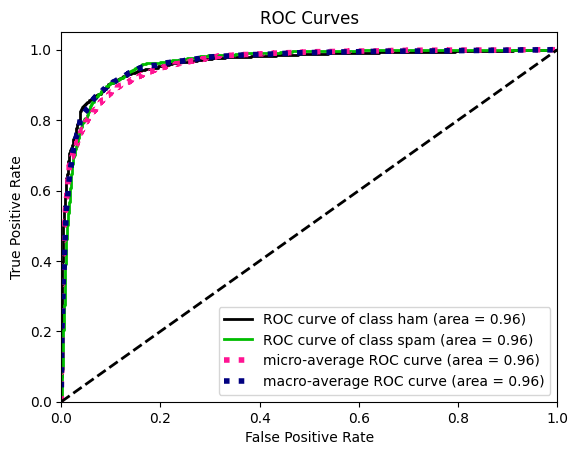

In [51]:
skplt.metrics.plot_roc_curve(y_test, pipeline.predict_proba(X_test))
plt.show()

#### Shap

In [52]:
shap.initjs()

In [53]:
X_shap = pipeline_transformer.fit_transform(X_train)
explainer = shap.LinearExplainer(pipeline.named_steps['model'],X_shap)

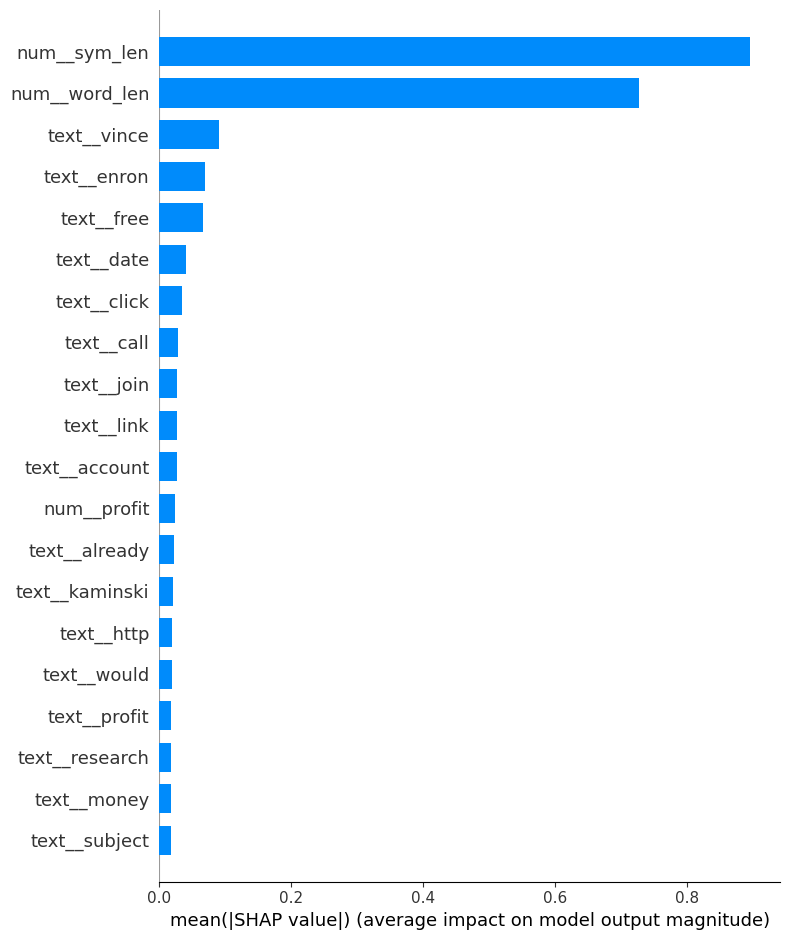

In [54]:
test_shap  = pipeline_transformer.transform(X_test.sample(150))
shap_values = explainer.shap_values(test_shap)
shap.summary_plot(shap_values, test_shap, feature_names=pipeline_transformer.named_steps['preprocessor'].get_feature_names_out(), plot_type='bar', show=True)

Видим множество фичей, пересекающихся с нашей гипотизой, про связь  рекламы "зароботка" и "бизнеса" - `offer`, `free`, `earn`

А так же слова призывающие куда-то нажать - `link`,`account`, `click`, `call`

In [55]:
X_train

sym_len  word_len  profit  \
15414      133        26       0   
7044        95        20       0   
13969      759       145       0   
13537      757       135       0   
6553       741       139       0   
...        ...       ...     ...   
13428      190        28       0   
5392       486        89       0   
860        474        79       0   
15806      326        61       0   
7274       753       144       0   

                                             text_lemmas  
15414  aerobics classes worth talents dance academy g...  
7044   sleeping going take haha spys online checking ...  
13969  agenda next week spoke anjam gave information ...  
13537  announces basic training program internet mess...  
6553   update meteorologist search great work mike ar...  
...                                                  ...  
13428  date business abbey national received takeover...  
5392   drogi vincenty skoro byles tyle mily zadzonile...  
860    account sale total mythics account level prime...  
15806  agenda work valuation visioning session attach...  
7274   resco database customer capture steve makes se...  

[11386 rows x 4 columns]

### LogisticRegression + feature selection

In [56]:
from sklearn.feature_selection import SelectKBest, chi2,mutual_info_classif ,SelectPercentile
bestfeatures = SelectPercentile(score_func = chi2)
X_train_vec = pipeline_transformer.fit_transform(X_train)
featurs_ = bestfeatures.fit(X_train_vec, y_train)

In [57]:
dfscores = pd.DataFrame(featurs_.scores_)
dfcolumns = pd.DataFrame(np.arange(X_train_vec.shape[1]))

In [58]:
featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Specs', 'Score']

In [59]:
n = featureScores.nlargest(100, 'Score')
arr = np.array(n['Specs'])
arr_name = pipeline_transformer.named_steps['preprocessor'].get_feature_names_out()
Scores = {'name': [],'score':[]}
for i in arr:
    Scores['name'].append(arr_name[i])
    Scores['score'].append( featureScores.Score[i])
Scores = pd.DataFrame(Scores)
Scores

name      score
0              num__profit  51.721791
1               text__earn  39.603106
2              text__enron  37.862672
3              text__vince  37.601021
4               text__free  37.436803
..                     ...        ...
95             text__nokia   8.409904
96       text__aircel free   8.368228
97  text__blyk aircel free   8.368228
98             text__apply   8.341570
99             text__wrote   8.319896

[100 rows x 2 columns]

Попробуем обучить LogisticRegression только на top100 фичей

In [60]:
X_test_vec = pipeline_transformer.transform(X_test)

In [61]:
new_X_train = X_train_vec[:, arr]
new_X_test = X_test_vec[:, arr]
new_X_train

<11386x100 sparse matrix of type '<class 'numpy.float64'>'
	with 17894 stored elements in Compressed Sparse Row format>

Accuracy: 0.8096701495595164
F1: 0.7278762133409669
AUC: 0.8755043409344717


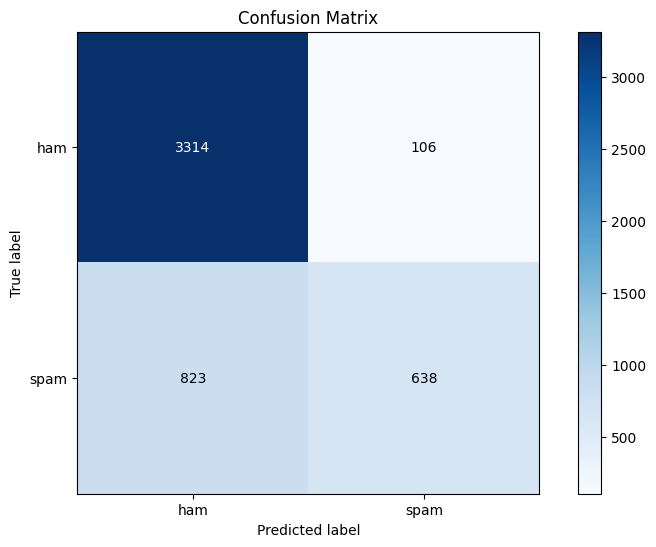

In [62]:
clf = LogisticRegression(penalty='l2', solver='liblinear')

clf.fit(new_X_train, y_train)
y_pred = clf.predict(new_X_test)

print('Accuracy:',accuracy_score(y_pred, y_test))
print('F1:',f1_score(y_pred, y_test, average='macro'))
print('AUC:', roc_auc_score(y_test, clf.predict_proba(new_X_test)[:, 1]))
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=False, figsize=(10,6))
plt.show()

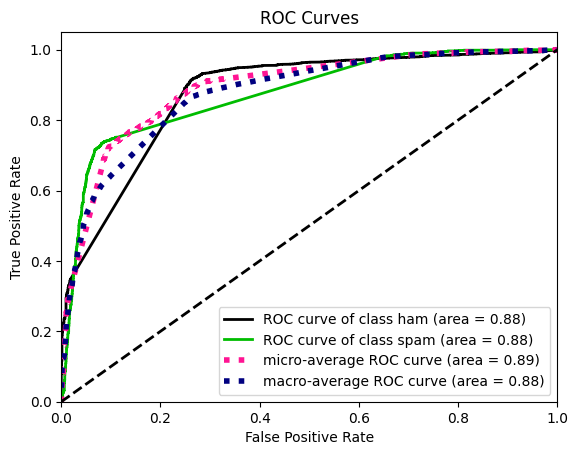

In [63]:
skplt.metrics.plot_roc_curve(y_test, clf.predict_proba(new_X_test))
plt.show()

Мы снизили число фич в 435 раз, при этом целевая метрика просела с 0.96 до 0.88

## CatBoost

Для векторизации будем использовать встроенную в `CatBoost` возможность работы с работы с текстом

In [64]:
from catboost import Pool

def fit_model(train_pool, validation_pool, **kwargs):
    model = CatBoostClassifier(
        eval_metric='AUC', # 'TotalF1',#"Accuracy",
        iterations=7500,
        learning_rate=0.05,
        use_best_model= True,
        task_type='GPU',
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=validation_pool,
        verbose=500,
    )

In [65]:
X = df[['text','sym_len','word_len','profit','text_lemmas']]
y = df['text_type']
X_train, X_test, y_train, y_test = tts(X, y,random_state=42, train_size=0.7, shuffle=True)

In [66]:
train_pool = Pool(
    X_train, y_train,
    text_features=['text', 'text_lemmas']
)


val_pool = Pool(
    X_test, y_test,
    text_features=['text', 'text_lemmas']
)

print('Train dataset shape: {}\n'.format(train_pool.shape))

cat_boost = fit_model(train_pool, val_pool)

Train dataset shape: (11386, 5)



Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9393613	best: 0.9393613 (0)	total: 418ms	remaining: 52m 12s
500:	test: 0.9841595	best: 0.9841757 (495)	total: 20.5s	remaining: 4m 47s
1000:	test: 0.9848008	best: 0.9848008 (1000)	total: 38.5s	remaining: 4m 9s
1500:	test: 0.9851249	best: 0.9851497 (1390)	total: 56.2s	remaining: 3m 44s
2000:	test: 0.9852268	best: 0.9852268 (2000)	total: 1m 38s	remaining: 4m 31s
2500:	test: 0.9851490	best: 0.9852524 (2175)	total: 2m 23s	remaining: 4m 47s
3000:	test: 0.9851039	best: 0.9852524 (2175)	total: 2m 50s	remaining: 4m 15s
3500:	test: 0.9849951	best: 0.9852524 (2175)	total: 3m 9s	remaining: 3m 36s
4000:	test: 0.9849374	best: 0.9852524 (2175)	total: 3m 29s	remaining: 3m 3s
4500:	test: 0.9849268	best: 0.9852524 (2175)	total: 3m 49s	remaining: 2m 32s
5000:	test: 0.9847675	best: 0.9852524 (2175)	total: 4m 8s	remaining: 2m 3s
5500:	test: 0.9847149	best: 0.9852524 (2175)	total: 4m 25s	remaining: 1m 36s
6000:	test: 0.9846428	best: 0.9852524 (2175)	total: 5m 1s	remaining: 1m 15s
6500:	test: 0.98

Accuracy: 0.9569760295021512
F1: 0.9479239276091738
AUC: 0.9852524306431147


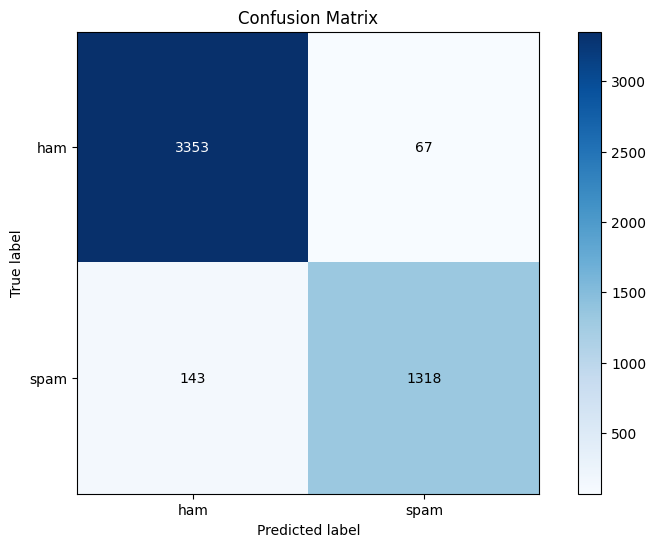

In [67]:
y_pred = cat_boost.predict(val_pool)
print('Accuracy:',accuracy_score(y_pred, y_test))
print('F1:',f1_score(y_pred, y_test, average='macro'))
print('AUC:', roc_auc_score(y_test, cat_boost.predict_proba(val_pool)[:, 1]))
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=False, figsize=(10,6))
plt.show()

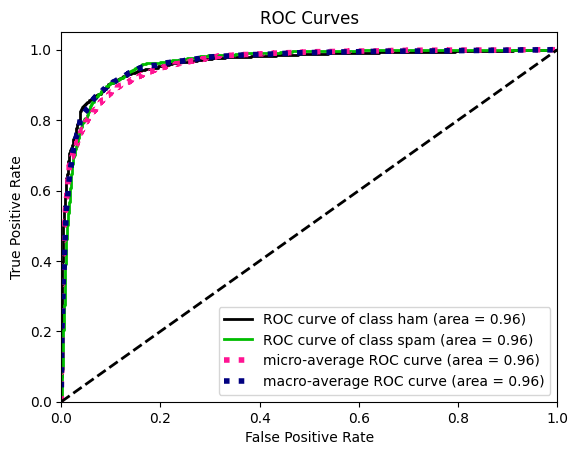

In [68]:
skplt.metrics.plot_roc_curve(y_test, pipeline.predict_proba(X_test))
plt.show()

### Shap

In [69]:
le.inverse_transform

<bound method LabelEncoder.inverse_transform of LabelEncoder()>

## BERT

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [71]:
model_name = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"

BERT_classifier = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
BERT_tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [72]:
df

text_type                                               text  \
0           ham  make sure alex knows his birthday is over in f...   
1           ham  a resume for john lavorato thanks vince i will...   
2          spam  plzz visit my website moviesgodml to get all m...   
3          spam  urgent your mobile number has been awarded wit...   
4           ham  overview of hr associates analyst project per ...   
...         ...                                                ...   
16273      spam  if you are interested in binary options tradin...   
16274      spam  dirty pictureblyk on aircel thanks you for bei...   
16275       ham  or you could do this g on mon 1635465 sep 1635...   
16276       ham  insta reels par 80 गंद bhara pada hai 👀 kuch b...   
16277       ham  alex s paper comments 1 in the sentence betwee...   

       text_type_cod  sym_len  word_len  profit  \
0                  0       86        16       0   
1                  0      520        97       0   
2                  1      126        22       0   
3                  1      139        23       0   
4                  0      733       127       0   
...              ...      ...       ...     ...   
16273              1      114        18       0   
16274              1      454        73       0   
16275              0      799       147       0   
16276              0      102        21       0   
16277              0      745       140       0   

                                             text_lemmas  
0      make sure alex knows birthday fifteen minutes ...  
1      resume john lavorato thanks vince moving right...  
2      plzz visit website moviesgodml movies free als...  
3      urgent mobile number awarded prize guaranteed ...  
4      overview associates analyst project david requ...  
...                                                  ...  
16273  interested binary options trading continue inf...  
16274  dirty pictureblyk aircel thanks valued member ...  
16275  could david rees wrote wrote razor spamassassi...  
16276  insta reels bhara pada kuch dalte cringe somet...  
16277  alex paper comments sentence think annualized ...  

[16267 rows x 7 columns]

In [73]:
X_train, X_val, y_train, y_val = tts(df['text'], df['text_type_cod'], random_state=42, test_size=0.3, shuffle=True)
X_train = X_train.tolist()
X_val = X_val.tolist()
y_train = y_train.tolist()
y_val = y_val.tolist()

train_encodings = BERT_tokenizer(X_train, truncation=True, padding=True)
val_encodings = BERT_tokenizer(X_val, truncation=True, padding=True)

In [74]:
class GroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

In [75]:
train_dataset = GroupsDataset(train_encodings, y_train)
valid_dataset = GroupsDataset(val_encodings, y_val)

In [76]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    pred_scores = softmax(pred.predictions.astype('float32'), axis=1)
    auc = roc_auc_score(labels, pred_scores[:, 1])
    return {
        'accuracy'      :acc,
        'f1 macro'      :f1,
        'AUC'           :auc,
            }

In [77]:
training_args = TrainingArguments(
    run_name = 'distilbert_VK',
    output_dir='./results',
    learning_rate=5e-5,
    max_steps = 700,
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    save_total_limit=4,
    load_best_model_at_end=True,
    logging_steps=100,
    save_steps=100,
    fp16=True,
    evaluation_strategy="steps")

trainer = Trainer(
    model=BERT_classifier.to(device),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

max_steps is given, it will override any value given in num_train_epochs


In [78]:
trainer.train()

TrainOutput(global_step=700, training_loss=0.225076630456107, metrics={'train_runtime': 337.3754, 'train_samples_per_second': 33.197, 'train_steps_per_second': 2.075, 'total_flos': 1483634864947200.0, 'train_loss': 0.225076630456107, 'epoch': 0.9831460674157303})

In [79]:
test_pred = trainer.predict(valid_dataset)

In [80]:
pred_scores = softmax(test_pred.predictions.astype('float32'), axis=1)
pred_scores

array([[9.9966526e-01, 3.3469600e-04],
       [9.9961406e-01, 3.8596606e-04],
       [9.6228522e-01, 3.7714817e-02],
       ...,
       [9.7049260e-01, 2.9507361e-02],
       [9.9645507e-01, 3.5449786e-03],
       [9.9878877e-01, 1.2113067e-03]], dtype=float32)

Accuracy: 0.9684490883015775
AUC: 0.9926959624706302
F1: 0.9621058560148158


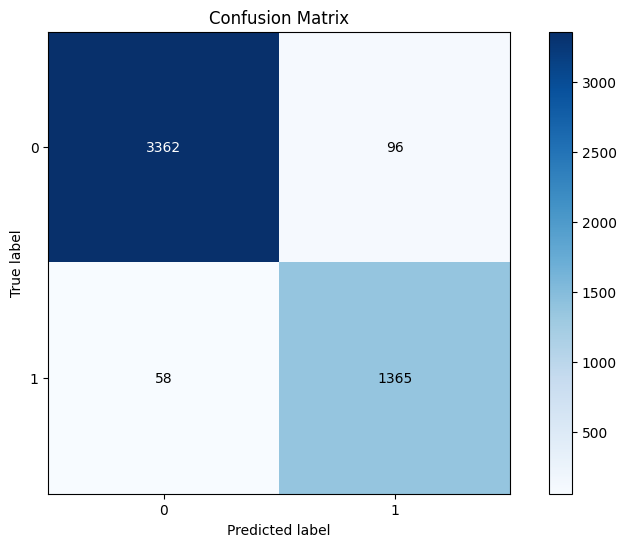

In [81]:
print('Accuracy:',accuracy_score(test_pred.predictions.argmax(-1), test_pred.label_ids))
print('AUC:', roc_auc_score(y_test, pred_scores[:, 1]))
print('F1:',f1_score(test_pred.predictions.argmax(-1), test_pred.label_ids, average='macro'))
skplt.metrics.plot_confusion_matrix(test_pred.predictions.argmax(-1), test_pred.label_ids, normalize=False, figsize=(10,6))
plt.show()

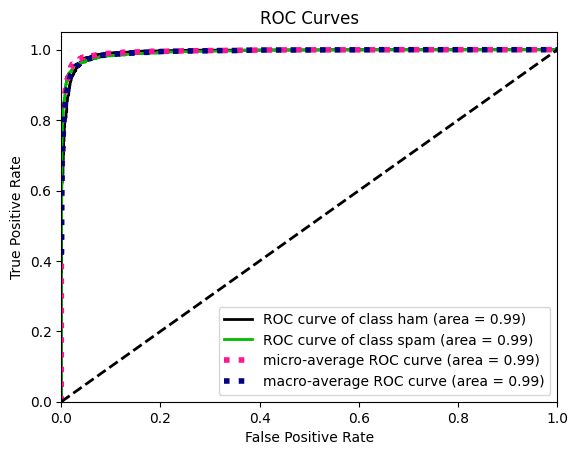

In [82]:
skplt.metrics.plot_roc_curve(y_test, pred_scores)
plt.show()

### Shap

In [88]:
class testDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

In [83]:
selected_categories = list(df.text_type.unique())
selected_categories

['ham', 'spam']

In [84]:
shap.initjs()

In [85]:
model = trainer.model

In [86]:
def f(x):
    tv = torch.tensor(
        [
            BERT_tokenizer.encode(v, padding="max_length", truncation=True)
            for v in x
        ]
    ).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:, 1])
    return val

explainer = shap.Explainer(f, BERT_tokenizer)

In [91]:
X_batch = X_val[:7]

print("Samples : ")
for text in X_batch:
    print(text)
    print()


X_encodings = BERT_tokenizer(X_batch, truncation=True, padding=True)
X_dataset = testDataset(X_encodings)

preds = trainer.predict(X_dataset)
preds_proba = softmax(preds.predictions.astype('float32'), axis=1)


print("Actual Target Values : {}".format([selected_categories[target] for target in y_val[:7]]))
print("Predicted Target Values : {}".format([selected_categories[target] for target in preds.predictions.argmax(-1)]))
print("Predicted Probabilities : {}".format([max(proba) for proba in preds_proba]))

shap_values = explainer(X_batch, fixed_context=1)

Samples : 
enron opportunities thanks vince we will follow up with this lsu graduate hope you are doing well regards lynn dunphy vince j kaminski 02 15 2000 08 53 am to lynn dunphy hou ect ect cc vince j kaminski hou ect ect subject enron opportunities lynn i am forwarding you the resume of a very bright and motivated young man who attended a lecture i gave recently at lsu i think we should consider him for an analyst position vinceforwarded by vince j kaminski hou ect on 02 15 2000 08 52 am richard c iles on 09 14 2000 11 14 56 am please respond to richard c iles to cc subject enron opportunities dr kaminski here is my resume and cover letter thanks richard iles enron cover and

biliana s resume geynille i understand you are in charge of recruiting at the uofh i am forwarding to you the resume of one of the students of the university of houston she is involved with the international organization called aiesec and i was most impressed by her organizational skills and professional attit

Actual Target Values : ['ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham']
Predicted Target Values : ['ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham']
Predicted Probabilities : [0.99966526, 0.99961406, 0.962356, 0.9990746, 0.9966036, 0.99603915, 0.88418937]


In [92]:
shap.text_plot(shap_values)

Красным обозначены слова в большей степени влияющие на пренадлежность примера к классу `spam`, синим - к классу `ham`

Видим, что в 1ом примере слова `digital currency` и `million` стали определяющими

Во 3ем примере так же выделяются -  `earn`, `$10000`, `$5000`, `$`

# Predict

Для финально предсказания будем использовать `distilbert` так как он дал зоть и не на много, но лучшуий `AUC`

In [93]:
test = pd.read_csv("/content/test_spam.csv")
test

text
0     j jim whitehead ejw cse ucsc edu writes j you ...
1     original message from bitbitch magnesium net p...
2     java for managers vince durasoft who just taug...
3                  there is a youtuber name saiman says
4     underpriced issue with high return on equity t...
...                                                 ...
4065  husband to wifetum meri zindagi hoorwifeor kya...
4066  baylor enron case study cindy yes i shall co a...
4067                           boring as compared to tp
4068  hellogorgeous hows u my fone was on charge lst...
4069  energy conference mark we are really swamped a...

[4070 rows x 1 columns]

In [95]:
X_encodings = BERT_tokenizer(test['text'].tolist(), truncation=True, padding=True)
X_test = testDataset(X_encodings)

preds = trainer.predict(X_test)

In [98]:
test["score"] = softmax(preds.predictions.astype('float32'), axis=1)[:, 1]#le.inverse_transform(preds.predictions.argmax(-1))
test

text     score
0     j jim whitehead ejw cse ucsc edu writes j you ...  0.002230
1     original message from bitbitch magnesium net p...  0.032744
2     java for managers vince durasoft who just taug...  0.000924
3                  there is a youtuber name saiman says  0.003112
4     underpriced issue with high return on equity t...  0.988290
...                                                 ...       ...
4065  husband to wifetum meri zindagi hoorwifeor kya...  0.018142
4066  baylor enron case study cindy yes i shall co a...  0.000273
4067                           boring as compared to tp  0.000853
4068  hellogorgeous hows u my fone was on charge lst...  0.002642
4069  energy conference mark we are really swamped a...  0.000673

[4070 rows x 2 columns]

In [99]:
test.to_csv("submission_Berezin.csv", index = False)